In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
root_path      = os.getcwd()
metrics_by_class_path = root_path + "\\metrics_by_class"
metrics_path   = root_path + "\\metrics"

Path(metrics_by_class_path).mkdir(parents = True, exist_ok = True)
Path(metrics_path).mkdir(parents = True, exist_ok = True)

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.rcParams["figure.figsize"] = (10, 6)
#plt.rcParams["font.family"] = "Times New Roman"

In [4]:
def add_metrics(df):
    df['GT']       = df['TP'] + df['FN']
    df['IoU']      = df['TP'] / (df['TP'] + df['FN'] + df['FP'])
    df['Accuracy'] = (df['TP'] + df['TN']) / (df['TP'] + df['FN'] + df['FP'] + df['TN'])
    
    return df

def mIoU(df):
    mIoU = df['IoU'].groupby(level = 0).agg(['mean'])
    mIoU.columns = ['mIoU']
    return mIoU

def fwIoU(df):
    fwIoU = (df['GT'] * df['IoU']).groupby(level=0).agg(['sum']) / df['GT'].groupby(level=0).agg(['sum'])
    fwIoU.columns = ['fwIoU']
    return fwIoU

def mAccuracy(df):
    mAcc = df['Accuracy'].groupby(level = 0).agg(['mean'])
    mAcc.columns = ['mAccuracy']
    return mAcc

#def fwAccuracy(df):
#    fwAcc = (df['GT'] * df['Accuracy']).groupby(level=0).agg(['sum']) / df['GT'].groupby(level=0).agg(['sum'])
#    fwAcc.columns = ['fwAccuracy']
#    return fwAcc

def read_csv(name):
    return add_metrics(pd.read_csv(name).set_index(['Threshold','Class']))

In [5]:
def df_plt_class_metric(dfs, t, names, metric, task, saving_path, order = None, 
                     ylim = 1, show = False, save = False):
    
    df = pd.concat([d[metric] for d in dfs], axis=1)
    df.columns = [f'{n} - {metric}' for n in names]
    
    if order is not None:
        df = df.reindex(df.index[order])
    
    fig, ax = plt.subplots()
    
    ind = np.arange(len(df))
    k = len(dfs)
    width = 0.6 / k
    
    for i, n in enumerate(names):
        ax.bar(ind + i*width, df[f'{n} - {metric}'], width, label = n)

    ax.set_ylabel(metric, fontsize = 12)
    ax.set_xlabel('Class', fontsize = 12)
    
    ax.legend()
    plt.xticks(ind + ((k-1)* width / k), df.index, rotation = 45)
    plt.ylim([0, ylim])

    if show:
        plt.show()
    if save:    
        fig.savefig(saving_path + f"\\{task}_segmentation_{metric}{t}.jpg")
        fig.savefig(saving_path + f"\\{task}_segmentation_{metric}{t}.eps")
        
    return df

In [6]:
def df_plt_metric(dfs, names, metric, task, saving_path, ylim = 1, show = False, save = False):
    
    fig, ax = plt.subplots()
    
    ind = np.arange(len(dfs[0]))
    k   = len(dfs)
    width = 0.6 / k
    
    for i, n in enumerate(names):
        ax.bar(ind + i*width, dfs[i][metric], width, label = n)

    ax.set_ylabel(metric, fontsize = 12)
    ax.set_xlabel('Threshold', fontsize = 12)
    
    ax.legend()
    plt.xticks(ind + ((k-1)* width / k), dfs[0].index)
    plt.ylim([0, ylim])

    if show:
        plt.show()
    if save:
        flag = 'I' if "IoU" in metric else 'A'
        
        fig.savefig(saving_path + f"\\{task}_segmentation_{flag}_{metric}.jpg")
        fig.savefig(saving_path + f"\\{task}_segmentation_{flag}_{metric}.eps")
        
    df = pd.concat([d[metric] for d in dfs], axis=1)
    df.columns = [f'{n} - {metric}' for n in names]
    return df 

In [169]:
def df_plt_metric_2(dfs1, names1, dfs2, names2,
                 metric, task, saving_path, ylim = 1, show = False, save = False):
    
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [len(dfs1[0].index), len(dfs2[0].index)]})
    
    ind1   = np.arange(len(dfs1[0]))
    k1     = len(dfs1)
    width1 = 0.6 / k1
    
    ind2   = np.arange(len(dfs2[0]))
    k2     = len(dfs2)
    width2 = 0.6 / k2
    
    for i, n in enumerate(names1):
        ax[0].bar(ind1 + i*width1, dfs1[i][metric], width1, label = n, color = plt.get_cmap("tab10")(i+1))
        
    for i, n in enumerate(names2):
        ax[1].bar(ind2 + i*width2, dfs2[i][metric], width2, label = n)

    ax[0].set_ylabel(metric, fontsize = 12)
    ax[0].set_xlabel('Threshold', fontsize = 12)
    
    #ax[1].set_ylabel(metric, fontsize = 12)
    ax[1].set_xlabel('Threshold', fontsize = 12)
    
    ax[0].legend()
    ax[1].legend()
    
    plt.sca(ax[0])
    plt.xticks(ind1 + ((k1-1)* width1 / k1), dfs1[0].index)
    plt.ylim([0, ylim])
    
    plt.sca(ax[1])
    plt.xticks(ind2 + ((k2-1)* width2 / k2), dfs2[0].index)
    plt.ylim([0, ylim])
    plt.margins(1)

    if show:
        fig.tight_layout()
        plt.show()
    if save:
        flag = 'I' if "IoU" in metric else 'A'
        
        fig.savefig(saving_path + f"\\{task}_segmentation_{flag}_{metric}.jpg")
        fig.savefig(saving_path + f"\\{task}_segmentation_{flag}_{metric}.eps")
        
    df = pd.concat([d[metric] for d in dfs1] + [d[metric] for d in dfs2], axis=1)
    df.columns = [f'{n} - {metric}' for n in (names1 + names2)]
    return df

In [8]:
ogc         = read_csv('object_grabcut.csv')
ogcam_PF_PB = read_csv('object_grabcutcam_PF_PB.csv')
ogcam_F_PF  = read_csv('object_grabcutcam_F_PF.csv')
ogcam_F_PB  = read_csv('object_grabcutcam_F_PB.csv')

ccam        = read_csv('class_cam.csv')
cgcam_PF_PB = read_csv('class_grabcutcam_PF_PB.csv')
cgcam_F_PF  = read_csv('class_grabcutcam_F_PF.csv')
cgcam_F_PB  = read_csv('class_grabcutcam_F_PB.csv')

In [9]:
def ranking_class(dfs):
    IoU_rank = np.zeros(20)
    Acc_rank = np.zeros(20)
    
    for df in dfs:
        df = df[['IoU', 'Accuracy']].groupby(level = 1).agg(['mean'])
        dfIoU = df['IoU']['mean']
        dfAcc = df['Accuracy']['mean']
        IoU_rank = np.add(IoU_rank, dfIoU.tolist() / dfIoU.mean())
        Acc_rank = np.add(IoU_rank, dfAcc.tolist() / dfAcc.mean())
        
    return np.argsort(- IoU_rank), np.argsort(- Acc_rank)

In [10]:
dfs = [ogc, ogcam_PF_PB, ogcam_F_PF, ogcam_F_PB, ccam, cgcam_PF_PB, cgcam_F_PF, cgcam_F_PB]

thresholds     = (np.arange(1, 10) / 10).tolist()
class_metrics  = ['IoU', 'Accuracy']
class_rank     = ranking_class(dfs)
metrics        = ['mIoU', 'fwIoU', 'mAccuracy']
metrics_fun    = [mIoU, fwIoU, mAccuracy]

ob_techs       = [ogcam_PF_PB, ogcam_F_PF, ogcam_F_PB]
ob_techs_names = ['grabcut-cam PF PB', 'grabcut-cam F PF', 'grabcut-cam F PB']

c_techs        = [ccam, cgcam_PF_PB, cgcam_F_PF, cgcam_F_PB]
c_techs_names  = ['cam', 'grabcut-cam PF PB', 'grabcut-cam F PF', 'grabcut-cam F PB']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


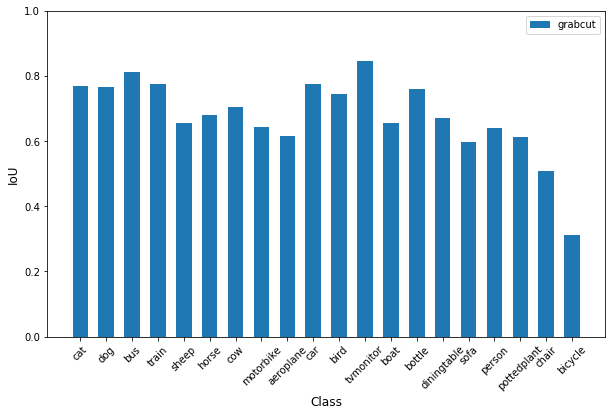

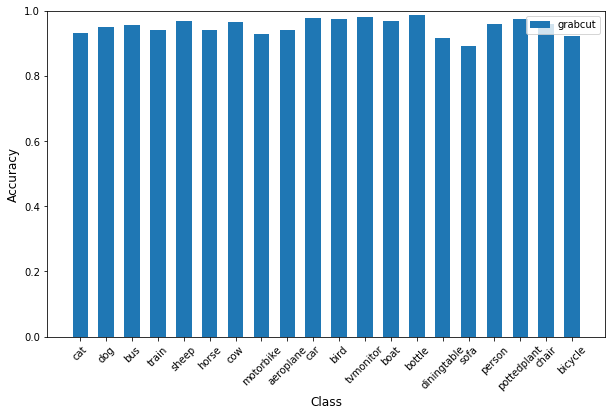

In [165]:
for (m, r) in zip(class_metrics, class_rank):
    for t in thresholds:
        df_plt_class_metric([df.loc[t] for df in ob_techs],
                         f'_0{int(t*10)}', 
                         ob_techs_names, 
                         m,
                         'Object', metrics_by_class_path,
                         order = r,
                         ylim = 1, show = False, save = True)
        
        df_plt_class_metric([df.loc[t] for df in c_techs],
                         f'_0{int(t*10)}', 
                         c_techs_names, 
                         m,
                         'Class', metrics_by_class_path,
                         order = r,
                         ylim = 1, show = False, save = True)
    
    df_plt_class_metric([ogc.loc['-']],
                     "", 
                     ['grabcut'], 
                     m,
                     'Object', metrics_by_class_path,
                     order = r,
                     ylim = 1, show = False, save = True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,grabcut-cam PF PB - IoU,grabcut-cam F PF - IoU,grabcut-cam F PB - IoU,grabcut - IoU
Class,,,,
cat,0.3,0.8,0.5,0.8
dog,0.3,0.8,0.5,0.8
bus,0.3,0.8,0.4,0.8
train,0.3,0.8,0.5,0.8
sheep,0.3,0.7,0.4,0.7
horse,0.4,0.7,0.5,0.7
cow,0.3,0.7,0.5,0.7
motorbike,0.3,0.7,0.5,0.6
aeroplane,0.5,0.6,0.6,0.6


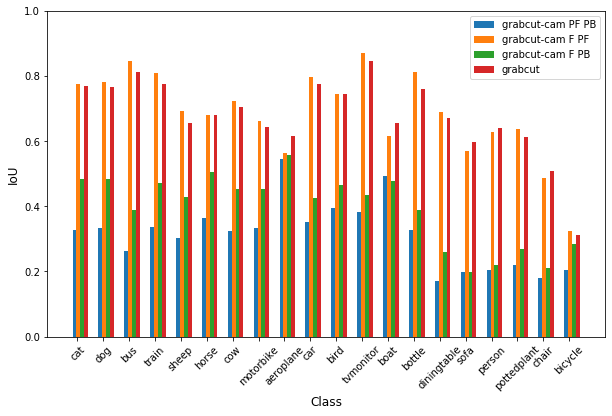

In [168]:
df_plt_class_metric([df.loc[0.6] for df in ob_techs] + [ogc.loc['-']],
                         f'_0{int(0.6*10)}', 
                         ob_techs_names + ['grabcut'], 
                         'IoU',
                         'Object_p', metrics_by_class_path,
                         order = class_rank[0],
                         ylim = 1, show = False, save = True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


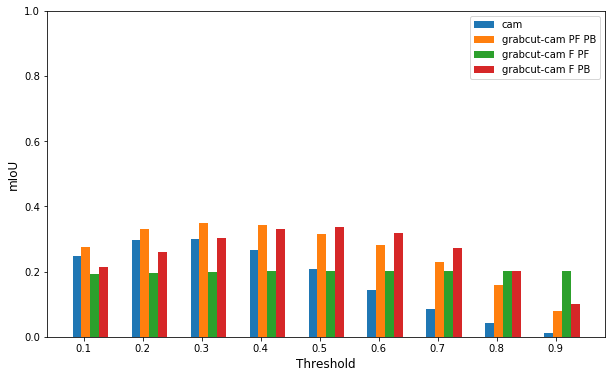

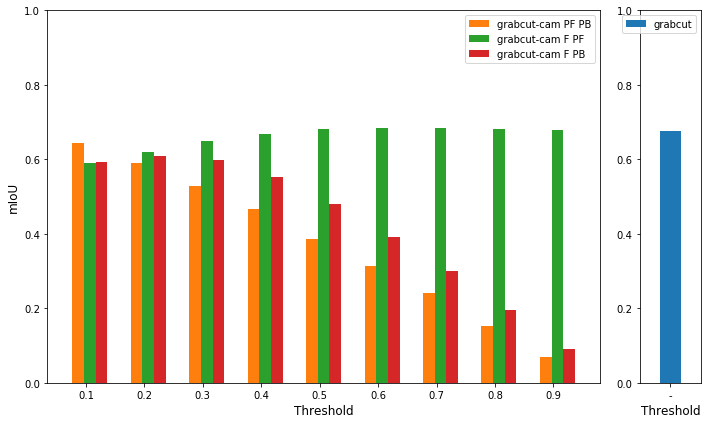

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


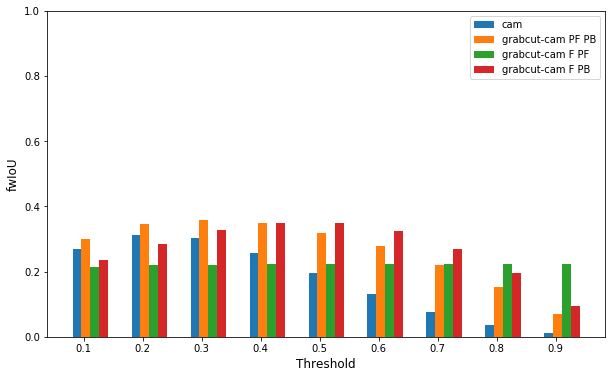

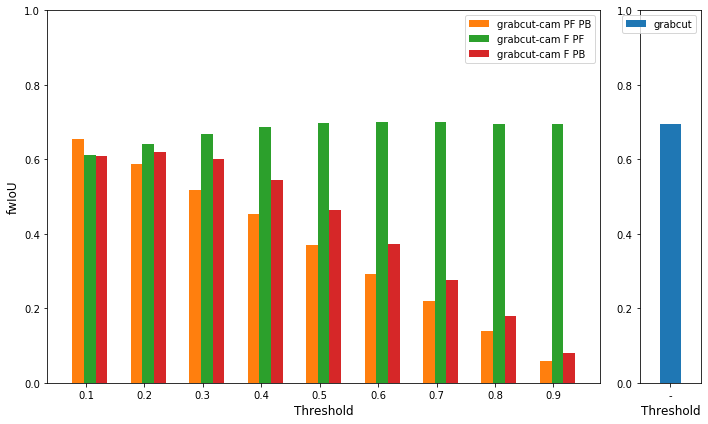

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


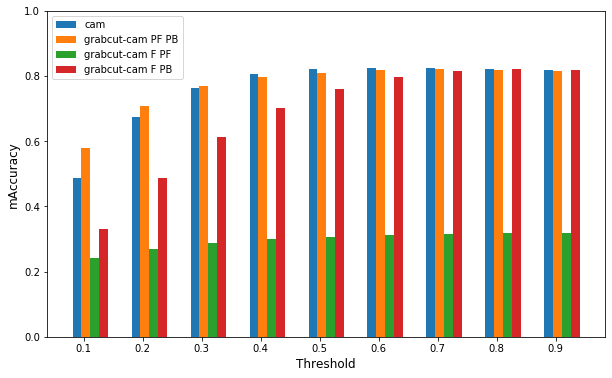

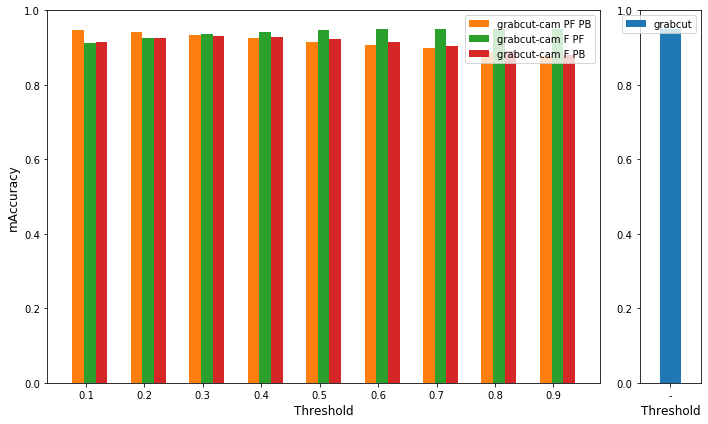

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [170]:
cdfs = []
odfs = []

for (m, f) in zip(metrics, metrics_fun):
    cdfs.append(df_plt_metric([f(df) for df in c_techs], 
               c_techs_names, 
               m, 
               'Class', 
               metrics_path, ylim = 1, show = False, save = True))
    
    odfs.append(df_plt_metric_2([f(df) for df in ob_techs], 
               ob_techs_names,
               [f(ogc)], 
               ['grabcut'],
               m, 
               'Object', 
               metrics_path, ylim = 1, show = True, save = True))
    

In [34]:
for cdf, odf, m in zip(cdfs, odfs, metrics):
    print(pd.DataFrame([cdf.max(),  cdf.idxmax()], index = ['max', 'argmax t']))
    print("")
    print(f'Best class technique for {m} is \"{cdf.max().idxmax()[:-(3 + len(m))]}\" with {m} = {cdf.max().max():.3f}')
    print("\n")
    print(pd.DataFrame([odf.max(),  odf.idxmax()], index = ['max', 'argmax t']))
    print("")
    print(f'Best object technique for {m} is \"{odf.max().idxmax()[:-(3 + len(m))]}\" with {m} = {odf.max().max():.3f}')
    print("_____________________________________________________________________\n")

          cam - mIoU  grabcut-cam PF PB - mIoU  grabcut-cam F PF - mIoU  grabcut-cam F PB - mIoU
max            0.300                     0.349                    0.202                    0.337
argmax t       0.300                     0.300                    0.700                    0.500

Best class technique for mIoU is "grabcut-cam PF PB" with mIoU = 0.349


          grabcut-cam PF PB - mIoU  grabcut-cam F PF - mIoU  grabcut-cam F PB - mIoU grabcut - mIoU
max                          0.645                    0.685                    0.608          0.677
argmax t                     0.100                    0.600                    0.200              -

Best object technique for mIoU is "grabcut-cam F PF" with mIoU = 0.685
_____________________________________________________________________

          cam - fwIoU  grabcut-cam PF PB - fwIoU  grabcut-cam F PF - fwIoU  grabcut-cam F PB - fwIoU
max             0.313                      0.358                     0.224                 

In [115]:
def float_to_str(x):
    if not isinstance(x, str):
        return f'{x:.1f}'
    else:
        return x

pd.options.display.float_format = '{:,.1f}'.format

In [126]:
c_best = pd.DataFrame([cdfs[0].max(),  cdfs[0].idxmax()], index = ['max', 'argmax t'])

c_tab_or = pd.concat([c_techs[i].loc[c_best[n + ' - mIoU'].loc['argmax t']]  
                   for i,n in enumerate(c_techs_names)], axis = 0, 
                  keys = [f'{n} ' + float_to_str(c_best[n + ' - mIoU'].loc['argmax t']) for n in c_techs_names])

In [151]:
c_tab = c_tab_or[['IoU', 'Accuracy']]
c_tab = c_tab.stack().unstack(level=1)
c_tab_metric = pd.concat([mIoU(c_tab_or), fwIoU(c_tab_or), mAccuracy(c_tab_or)], axis = 1)
c_tab.index.names = ['Technique', 'Metric']
c_tab_metric.index.names = ['Technique']
c_tab_merge = c_tab.join(c_tab_metric, on=['Technique']) * 100

In [154]:
print(c_tab_merge[c_tab_merge.columns[:12]])
print(c_tab_merge[c_tab_merge.columns[12:]])

                                aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  diningtable  dog
Technique             Metric                                                                                       
cam 0.3               IoU            34.6     20.3  29.4  25.6    23.3 37.8 31.4 42.7   12.7 37.2         21.7 42.6
                      Accuracy       82.4     83.3  84.2  76.8    76.1 71.2 76.5 79.8   63.6 82.1         67.5 84.8
grabcut-cam PF PB 0.3 IoU            44.6     15.9  38.1  30.1    22.9 46.5 32.4 53.6   13.5 49.3         26.3 52.1
                      Accuracy       86.8     76.9  86.8  79.0    74.3 74.8 74.6 82.2   61.9 84.6         68.9 86.2
grabcut-cam F PF 0.7  IoU            13.8      7.6  13.3  12.4    12.4 35.8 19.2 33.5   11.5 22.5         25.6 26.0
                      Accuracy       23.3     23.5  24.1  23.3    22.5 42.6 30.7 42.7   20.6 35.7         39.6 38.1
grabcut-cam F PB 0.5  IoU            39.2     15.1  32.5  25.8    22.5 4

In [160]:
c_tab_merge.to_csv('class_table.csv', float_format='%.1f')

In [106]:
o_techs = ob_techs + [ogc]
o_techs_names = ob_techs_names + ['grabcut']

In [116]:
o_best = pd.DataFrame([odfs[0].max(),  odfs[0].idxmax()], index = ['max', 'argmax t'])

o_tab_or = pd.concat([o_techs[i].loc[o_best[n + ' - mIoU'].loc['argmax t']]  
                   for i,n in enumerate(o_techs_names)], axis = 0, 
                  keys = [f'{n} ' + float_to_str(o_best[n + ' - mIoU'].loc['argmax t']) for n in o_techs_names])

In [155]:
o_tab = o_tab_or[['IoU', 'Accuracy']]
o_tab = o_tab.stack().unstack(level=1)
o_tab_metric = pd.concat([mIoU(o_tab_or), fwIoU(o_tab_or), mAccuracy(o_tab_or)], axis = 1)
o_tab.index.names = ['Technique', 'Metric']
o_tab_metric.index.names = ['Technique']
o_tab_merge = o_tab.join(o_tab_metric, on=['Technique']) * 100

In [156]:
print(o_tab_merge[o_tab_merge.columns[:12]])
print(o_tab_merge[o_tab_merge.columns[12:]])

                                aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  diningtable  dog
Technique             Metric                                                                                       
grabcut-cam PF PB 0.1 IoU            67.3     30.8  74.0  68.5    75.7 73.9 75.3 74.7   45.5 62.9         54.2 75.5
                      Accuracy       95.5     93.2  97.4  97.2    98.6 94.1 97.5 92.8   95.9 95.7         88.6 95.0
grabcut-cam F PF 0.6  IoU            56.2     32.5  74.5  61.6    81.0 84.6 79.5 77.6   48.5 72.4         68.8 78.0
                      Accuracy       92.4     91.5  97.1  95.9    98.8 96.4 97.9 93.1   95.4 96.5         91.7 95.2
grabcut-cam F PB 0.2  IoU            45.5     27.8  57.1  52.9    76.1 79.0 70.7 71.8   42.1 64.2         65.0 71.0
                      Accuracy       87.9     87.8  93.9  93.7    98.3 94.6 96.4 90.6   93.9 94.6         89.8 93.1
grabcut -             IoU            61.6     31.3  74.4  65.6    76.0 8

In [159]:
o_tab_merge.to_csv('object_table.csv', float_format='%.1f')